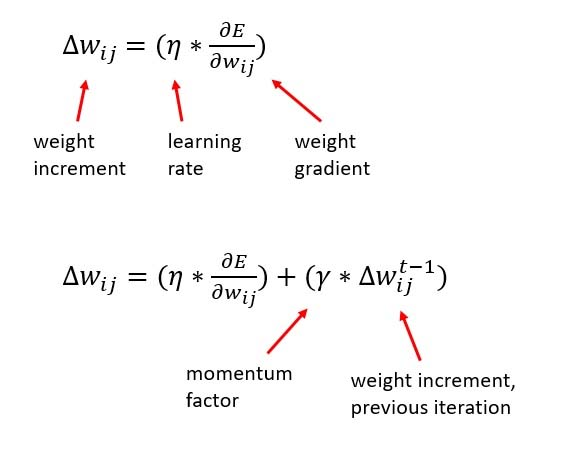

In [ ]:
# Implementing momentum

def BackwardPass(self, input_vec, desired):
    out_delta = (desired - self.out) * (self.out * (1 - self.out))  
    hid_delta = out_delta.dot(self.W2.T) * (self.hidout * (1 - self.hidout)) 
    '''
    matrix multiplication:
    https://www.tutorialspoint.com/numpy/numpy_dot.htm
    https://www.geeksforgeeks.org/numpy-dot-python/
    '''

    if self.vanilla == True:    # no momentum 
        self.W2 += (self.hidout.T.dot(out_delta) * self.learn_rate)
        self.B2 += (-1 * self.learn_rate * out_delta)

        self.W1 += (input_vec.T.dot(hid_delta) * self.learn_rate)
        self.B1 += (-1 * self.learn_rate * hid_delta)
        
    else:    # use momentum
        v2 = self.W2.copy()     # save previous weights - http://cs231n.github.io/neural-networks-3/#sgd
        v1 = self.W1.copy()
        b2 = self.B2.copy()
        b1 = self.B1.copy()

        self.W2 += (v2 * self.momenRate) + (self.hidout.T.dot(out_delta) * self.learn_rate)   # velocity update
        self.W1 += (v1 * self.momenRate) + (input_vec.T.dot(hid_delta) * self.learn_rate)   
        self.B2 += (b2 * self.momenRate) + (-1 * self.learn_rate * out_delta)     # velocity update
        self.B1 += (b1 * self.momenRate) + (-1 * self.learn_rate * hid_delta)   

In [ ]:
'''
Vanilla Gradient Descent:
gradient descent-based weight update useing the entire training data sets as a single batch
'''
for i in range(number_epochs): 
    params_grad = evaluate_gradient(loss_function, data, params)
    weights = weights - learning_rate * params_grad

In [ ]:
'''
Stocastic Gradient Descent:
compute the gradient for an instance of the dataset and then updates weight after gradients are computed
'''
for i in range(number_epochs):
    np.random.shuffle(data)    
    for example in data:
        params_grad = evaluate_gradient(loss_function, example, params)
        weights = weights - learning_rate * params_grad

In [ ]:
'''
Minibatch Gradient Descent:
combined vanilla and stochastic gradient descent,
using small or mini-batches to reduce the variance of the parameter updates for stable convergence
'''
for i in range(number_epochs):
    np.random.shuffle(data)
    for batch in get_batches(data, batch_size=50):
        params_grad = evaluate_gradient(loss_function, batch, params)
        weights = weights - learning_rate * params_grad

#### SGD and Momentum (from scratch)

In [ ]:
# useStocastic = True 
# False for vanilla BP with SGD (no shuffle of data)
# True for BP with SGD (shuffle of data at every epoch) 

# updateStyle = False
# True for Vanilla SGD
# False for momentum SGD

def BP_GD(self, trainTolerance):
    Input = np.zeros((1, self.Top[0]))   # Temp hold input
    Desired = np.zeros((1, self.Top[2])) 

    #minibatchsize = int(0.1 * self.TrainData.shape[0])   # TrainData.shape[0] = No. of instances (No. of rows)
    # Choose a mini-batch size for SGD - optional exercise to implement this

    Er = [] 
    epoch = 0
    bestRMSE = 10000    # Assign a large number in begining to maintain best (lowest RMSE)
    bestTrain = 0
    while  epoch < self.Max and bestTrain < self.minPerf :
        sse = 0

        for s in range(self.TrainData.shape[0]):
            if(self.stocasticGD == True):
                # Data shuffle in SGD: 
                # https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.randint.html
                pat = random.randint(0, self.TrainData.shape[0]-1)
                # random.randint(0, 9) returns a random integer in range [0, 9]
                
            else:
                pat = s    # no data shuffle in SGD

            Input[:] = self.TrainData[pat, :self.Top[0]]  
            Desired[:] = self.TrainData[pat, self.Top[0]:]  

            self.ForwardPass(Input)  
            self.BackwardPass(Input, Desired)
            sse += self.sampleEr(Desired)

        rmse = np.sqrt(sse / self.TrainData.shape[0] * self.Top[2])

        if rmse < bestRMSE:
            bestRMSE = rmse
            self.saveKnowledge()
            (bestRMSE, bestTrain) = self.TestNetwork(self.TrainData, trainTolerance)
            #Print(bestRMSE, bestTrain)

        Er = np.append(Er, rmse)

        epoch += 1  

    return (Er, bestRMSE, bestTrain, epoch)

In [ ]:
import random

random.randint(0, 5)

### Implementing Momentum and SGD in NN

In [ ]:
# Source: https://github.com/rohitash-chandra
# Sigmoid units used in hidden and output   
# This version will demonstrate momemntum and stocastic gradient descent 

import matplotlib.pyplot as plt
import numpy as np 
import random
import time
 
class Network:
    def __init__(self,Topo, Train, Test, MaxTime, MinPer, learnRate, use_stocasticGD, use_vanillalearning, momentum_rate): 
        self.Top = Topo       # NN topology [input, hidden, output]
        self.Max = MaxTime    # Max epocs
        self.TrainData = Train
        self.TestData = Test
        self.NumSamples = Train.shape[0]
        self.learn_rate = learnRate
        self.minPerf = MinPer
        
        # Initialise weights (W1 W2) and bias (b1 b2) of the network
        np.random.seed() 
        self.W1 = np.random.uniform(-0.5, 0.5, (self.Top[0], self.Top[1]))  
        #Print('self.W1: \n', self.W1)
        self.B1 = np.random.uniform(-0.5,0.5, (1, self.Top[1]))    # Bias in the hidden layer
        #Print('self.B1: \n', self.B1)
        self.BestB1 = self.B1
        self.BestW1 = self.W1 
        self.W2 = np.random.uniform(-0.5, 0.5, (self.Top[1] , self.Top[2]))   
        self.B2 = np.random.uniform(-0.5,0.5, (1, self.Top[2]))    # Bias in the output layer
        self.BestB2 = self.B2
        self.BestW2 = self.W2 
        self.hidout = np.zeros(self.Top[1])    # Output in the hidden layer
        self.out = np.zeros(self.Top[2])       # Output in the output layer

        self.hid_delta = np.zeros(self.Top[1])  # Output in the hidden layer
        self.out_delta = np.zeros(self.Top[2])  # Output in the output layer

        self.vanilla = use_vanillalearning    # Canonical batch training mode - use full data set - no SGD
        self.momenRate = momentum_rate
        self.stocasticGD = use_stocasticGD

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        # numerically stable with large exponentials
        exps = np.exp(x - x.max())
        return exps / np.sum(exps, axis=0)

    def sampleEr(self, actualout):
        error = np.subtract(self.out, actualout)
        sqerror = np.sum(np.square(error))/self.Top[2]
        return sqerror

    def ForwardPass(self, X): 
        z1 = X.dot(self.W1) - self.B1      # in the hidden layer
        self.hidout = self.sigmoid(z1)     # Output of the hidden layer   
        z2 = self.hidout.dot(self.W2) - self.B2   # in the output layer
        self.out = self.sigmoid(z2)        # Output of the output layer

    def BackwardPass(self, input_vec, desired):   
        out_delta = (desired - self.out) * (self.out * (1-self.out))  
        hid_delta = out_delta.dot(self.W2.T) * (self.hidout * (1-self.hidout)) 

        if self.vanilla == True:   # No momentum
            self.W2 += self.hidout.T.dot(out_delta) * self.learn_rate
            self.B2 += (-1 * self.learn_rate * out_delta)

            self.W1 += (input_vec.T.dot(hid_delta) * self.learn_rate) 
            self.B1 += (-1 * self.learn_rate * hid_delta)
            
        else:   # use momentum
            v2 = self.W2.copy()    # Save previous weights - http://cs231n.github.io/neural-networks-3/#sgd
            v1 = self.W1.copy()
            b2 = self.B2.copy()
            b1 = self.B1.copy()

            self.W2 += (v2 * self.momenRate) + (self.hidout.T.dot(out_delta) * self.learn_rate)   # velocity update
            self.W1 += (v1 * self.momenRate) + (input_vec.T.dot(hid_delta) * self.learn_rate)   
            self.B2 += (b2 * self.momenRate) + (-1 * self.learn_rate * out_delta)    # velocity update
            self.B1 += (b1 * self.momenRate) + (-1 * self.learn_rate * hid_delta)
            
    def TestNetwork(self, Data, tolerance):
        Input = np.zeros((1, self.Top[0]))   # temp hold input
        Desired = np.zeros((1, self.Top[2])) 
        nOutput = np.zeros((1, self.Top[2]))
        testSize = Data.shape[0]   # No. of instances

        clasPerf = 0
        sse = 0  
        self.W1 = self.BestW1
        self.W2 = self.BestW2    # load best knowledge
        self.B1 = self.BestB1
        self.B2 = self.BestB2    # load best knowledge

        for s in range(testSize):
            Input = Data[s, :self.Top[0]] 
            Desired = Data[s, self.Top[0]:] 

            self.ForwardPass(Input) 
            sse += self.sampleEr(Desired)

            pred_binary = np.where(self.out > (1 - tolerance), 1, 0)

            if((Desired == pred_binary).all()):   # all() = and, any() = or
                clasPerf += 1   

            #if(np.isclose(self.out, Desired, atol=erTolerance).any()):
                #clasPerf += 1  

        return (sse/testSize, float(clasPerf)/testSize*100)   # mse, accuracy ratio


    def saveKnowledge(self):
        self.BestW1 = self.W1
        self.BestW2 = self.W2
        self.BestB1 = self.B1
        self.BestB2 = self.B2 

        #Print(self.BestW1, self.BestW2, self.BestB1, self.BestB2)

    def BP_GD(self, trainTolerance):  
        Input = np.zeros((1, self.Top[0]))   # Temp hold input
        Desired = np.zeros((1, self.Top[2])) 

        # Choose a mini-batch size for SGD - optional exercise to implement this
        #minibatchsize = int(0.1* self.TrainData.shape[0])        

        Er = [] 
        epoch = 0
        bestRMSE = 10000   # assign a large number in begining to maintain best (lowest RMSE)
        bestTrain = 0
        
        while  epoch < self.Max and bestTrain < self.minPerf:
            sse = 0

            for s in range(self.TrainData.shape[0]):
                
                if(self.stocasticGD == True):
                    # Data shuffle in SGD:
                    # https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.randint.html
                    pat = random.randint(0, self.TrainData.shape[0]-1)
                    # random.randint(0, 9) returns a random integer in range [0, 9]
                    
                else:
                    pat = s    # no data shuffle in SGD

                Input[:] = self.TrainData[pat, :self.Top[0]]  
                Desired[:] = self.TrainData[pat, self.Top[0]:]  

                self.ForwardPass(Input)  
                self.BackwardPass(Input, Desired)
                sse += self.sampleEr(Desired)

            rmse = np.sqrt(sse/self.TrainData.shape[0]*self.Top[2])

            if rmse < bestRMSE:
                bestRMSE = rmse
                self.saveKnowledge()
                bestRMSE, bestTrain = self.TestNetwork(self.TrainData, trainTolerance)
                # sse/testSize, float(clasPerf)/testSize*100
                
                #Print(bestRMSE, bestTrain)

            Er = np.append(Er, rmse)

            epoch += 1  

        return (Er, bestRMSE, bestTrain, epoch)

def normalisedata(data, inputsize, outsize): # Normalise the data between [0,1]
    traindt = data[:, np.array(range(0,inputsize))]
    dt = np.amax(traindt, axis=0)
    tds = abs(traindt/dt) 
    return np.concatenate(( tds[:,range(0,inputsize)], data[:,range(inputsize,inputsize+outsize)]), axis=1)

def main():
    problem = 2    # [1,2,3] choose your problem 
    
    if problem == 1:
        TrDat = np.loadtxt("datasets/train.csv", delimiter=',')   # Iris classification problem (UCI dataset)
        TesDat = np.loadtxt("datasets/test.csv", delimiter=',')
        Hidden = 6
        Input = 4
        Output = 2
    #https://stats.stackexchange.com/questions/207049/neural-network-for-binary-classification-use-1-or-2-output-neurons

        TrainData = normalisedata(TrDat, Input, Output) 
        TestData = normalisedata(TesDat, Input, Output)
        MaxTime = 1000
        MinCriteria = 95    # Stop when learn 95 percent

    elif problem == 2:
        import pandas as pd
        import sklearn  
        from sklearn import datasets 
        from sklearn.model_selection import train_test_split 
        
        df = pd.read_csv('datasets/diabetes.csv') 
        #https://www.kaggle.com/uciml/pima-indians-diabetes-database/data?select=diabetes.csv
        #Print(df.shape)
        print(df.describe().transpose())
        #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transpose.html

        target_column = ['Outcome'] 
        predictors = list(set(list(df.columns)) - set(target_column))
        df[predictors] = df[predictors]/df[predictors].max() 
        #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html
        
        X = df[predictors].values
        y = df[target_column].values

        #https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
        print(X_train.shape); print(X_test.shape)

        TrainData = np.hstack((X_train,y_train))
        TestData = np.hstack((X_test,y_test))

        Hidden = 20
        Input = 8
        Output = 1  

        MaxTime = 5000
        MinCriteria = 95     # Stop when learn 95 percent 

    Topo = [Input, Hidden, Output] 
    MaxRun = 5    # Number of experimental runs 

    trainTolerance = 0.25    # [e.g., 0.15 would be seen as 0] [0.81 would be seen as 1]
    testTolerance = 0.49
    learnRate = 0.1  

    useStocastic = True    # False for vanilla BP with SGD (no shuffle of data)
                           # True for BP with SGD (shuffle of data at every epoch)
        
    updateStyle = True     # True for Vanilla SGD, False for momentum SGD

    momentum_rate = 0.001  # 0.1 ends up having very large weights...try and see

    trainPerf = np.zeros(MaxRun)
    testPerf = np.zeros(MaxRun)

    trainMSE = np.zeros(MaxRun)
    testMSE = np.zeros(MaxRun)
    Epochs = np.zeros(MaxRun)
    Time = np.zeros(MaxRun)

    for run in range(MaxRun):
        print(run, ' is experimental run') 

        fnn = Network(Topo, TrainData, TestData, MaxTime, MinCriteria, learnRate, useStocastic, updateStyle, momentum_rate)
        start_time=time.time()
        (erEp, trainMSE[run], trainPerf[run], Epochs[run]) = fnn.BP_GD(trainTolerance)

        Time[run] = time.time() - start_time
        (testMSE[run], testPerf[run]) = fnn.TestNetwork(TestData, testTolerance)
        print(trainMSE[run], trainPerf[run], testMSE[run], testPerf[run])

    print('classification performance for each experimental run: ') 
    print(trainPerf)
    print(testPerf)
    
    print('RMSE performance for each experimental run: ') 
    print(trainMSE)
    print(testMSE)
    
    print('Epocs and Time taken for each experimental run: ') 
    print(Epochs)
    print(Time)
    
    print('mean and std of classification performance: ') 

    print(np.mean(trainPerf), np.std(trainPerf))
    print(np.mean(testPerf), np.std(testPerf))

    print('mean and std of computational time taken: ')
    print(np.mean(Time), np.std(Time))

    # Fig of last run
    plt.figure()
    plt.plot(erEp)
    plt.ylabel('error')  
    #plt.savefig('pictures/out.png')
    
    
if __name__ == "__main__":
    main()

In [ ]:
df.describe().transpose()